In [3]:
# run feature importance using census data from 2015-2018
# assume long term trend from 2015-2018 is representative of the actual trend between each two years
# **reading from all_data_retention_df (Parquet file with ZIP codes as text)
# there are 132 missing zip codes from the census data, including Puerto Rico zip codes: removed all loan entries iith missing census data

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from seaborn import heatmap
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import re

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio

from sklearn.ensemble import RandomForestClassifier

pio.renderers.default = 'browser'

In [4]:
df = pd.read_parquet('all_data_retention_df')

#Drop Rows in which the Account IDs don't match
ID_noMatch_indexes = df[df["Match?"]!=1.0].index
df.drop(ID_noMatch_indexes, inplace = True)

# remove blank rows
df.dropna(axis='index',subset=['Branch'], inplace = True)

years = [2015, 2018]

# exclude race columns
cols_race = ['white', 'black', 'american_indian', 'asian', 'pacific_islander', 'other_race', 'multi_race', 'hispanic_latino']

dfs = [pd.DataFrame()]*len(years)

for i in range(len(dfs)):
    dfs[i] = pd.read_excel('queryData_' + str(years[i]) + '.xlsx', dtype = {'zipcode' : 'object'})
    dfs[i].drop(cols_race, axis = "columns", inplace = True)
    
# dfs[0].head()

In [5]:
# insert columns for census data, excluding zip code
for col in dfs[0].columns:
    if col != 'zipcode':
        df.insert(len(df.columns)-3,col + '_change', 0.1)

# calculate change in census data between the two years
# store the change in census data in Grameen DataFrame
df_change = dfs[0].copy()
for z in df_change['zipcode'].unique():
    dif = dfs[1].loc[dfs[1]['zipcode'] == z, 'total_pop':'edu'].to_numpy() - dfs[0].loc[dfs[0]['zipcode'] == z, 'total_pop':'edu'].to_numpy()
    df_change.loc[df_change['zipcode']==z, 'total_pop':'edu'] = dif
    df.loc[df['Zip Code (Member)']==z, 'total_pop_change':'edu_change'] = dif

# store zip codes w/ NaNs in an array
zips_nan = df.loc[(df['total_pop_change'].isna()) | (df['median_income_change'].isna()) | (df['median_home_val_change'].isna()) | (df['median_gross_rent_change'].isna()) | (df['edu_change'].isna()), 'Zip Code (Member)'].unique().tolist()

# remove any additional rows/zip codes that had missing census data
df.dropna(axis='index',subset=['total_pop_change', 'median_income_change', 'median_home_val_change', 'median_gross_rent_change', 'edu_change'], inplace = True)

# store zip codes that are missing census data, then remove them from dataset
zips_missing = df.loc[df['total_pop_change']==0.1, 'Zip Code (Member)'].unique().tolist()

# only keep rows with valid census data and reset index
df = df[df['total_pop_change'] != 0.1].reset_index(drop = True)

# remove any other rows w/ invalid data
df = df[(df['total_pop_change']<600000000) & (df['median_income_change']<600000000) & (df['median_home_val_change']<600000000) & (df['median_gross_rent_change']<600000000) & (df['edu_change']<600000000)].reset_index(drop = True)
df_change.head()

,zipcode,total_pop,median_income,median_home_val,median_gross_rent,edu
0,46001,-439.0,7381.0,2400.0,91.0,34.0
1,46012,239.0,175.0,-1300.0,72.0,168.0
2,46032,4284.0,8692.0,26100.0,91.0,2674.0
3,46038,1893.0,9355.0,21600.0,131.0,1562.0
4,46060,2650.0,12285.0,18500.0,128.0,318.0


In [6]:
# df.to_parquet(fname='gentrification_df', compression=None)

In [7]:
# SEED = 0

# Divide X and ys into wanted columns
col_y = ['retention_1', 'retention_2', 'retention_3']
col_x = ['total_pop_change', 'median_income_change', 'median_home_val_change', 'median_gross_rent_change', 'edu_change']
y = df[col_y]
X = df[col_x]

# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

In [13]:
SEED = 10

# LASSO Regression
lasso_model = dict()
lasso_results = dict()

# SVM Regression
svm_model = dict()
svm_results = dict()

# Random Forest Regression
rf_model = dict()
rf_results = dict()

# XGBOOST Regression
xgb_model = dict()
xgb_results = dict()

models = ["RF", "XGB"]
# models = ["LASSO","SVM", "RF", "XGB"]
# SVM and LASSO taking a while to work....


for model in models:
    print(model)
    for target in y.columns:
        # create model
        if model == "LASSO":
            reg = LassoCV(cv=3, random_state = SEED)
        elif model == "SVM":
            reg = SVR()
        elif model == "RF":
#             reg = RandomForestRegressor(random_state = SEED)
            reg = RandomForestClassifier(random_state = SEED)
        elif model == "XGB":
#             reg = xgb.XGBRegressor(objective ='reg:squarederror', scoring='r2', random_state = SEED)
            reg = xgb.XGBRegressor(objective ='reg:squarederror', scoring='r2', random_state = SEED)

        # train model
        reg.fit(X_train, y_train[target])
        print(target, "Model Trained")

        # score the model
        train_score = reg.score(X_train, y_train[target])
        test_score = reg.score(X_test, y_test[target])
        print(target, "Model Scored")
        
        # store results
        if model == "LASSO":
            lasso_model[target] = reg
            lasso_results[target] = (train_score, test_score)
        elif model == "SVM":
            svm_model[target] = reg
            svm_results[target] = (train_score, test_score)
        elif model == "RF":
            rf_model[target] = reg
            rf_results[target] = (train_score, test_score)
        elif model == "XGB":
            xgb_model[target] = reg
            xgb_results[target] = (train_score, test_score)
        print(target, "Results Stored")

# gather all results into one data frame
lasso = pd.DataFrame(lasso_results).T
svm = pd.DataFrame(svm_results).T
rf = pd.DataFrame(rf_results).T
xgboost = pd.DataFrame(xgb_results).T

lasso["model"] = "LASSO"
svm["model"] = "SVM"
rf["model"] = "RF"
xgboost["model"] = "XGBoost"
result = lasso.append([svm,rf,xgboost])

print(result)

RF


C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



retention_1 Model Trained
retention_1 Model Scored
retention_1 Results Stored


C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



retention_2 Model Trained
retention_2 Model Scored
retention_2 Results Stored


C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



retention_3 Model Trained
retention_3 Model Scored
retention_3 Results Stored
XGB
retention_1 Model Trained
retention_1 Model Scored
retention_1 Results Stored
retention_2 Model Trained
retention_2 Model Scored
retention_2 Results Stored
retention_3 Model Trained
retention_3 Model Scored
retention_3 Results Stored
               model         0         1
retention_1       RF  0.870407  0.866825
retention_2       RF  0.717936  0.718336
retention_3       RF  0.540959  0.534228
retention_1  XGBoost  0.015089 -0.008904
retention_2  XGBoost  0.131384  0.116217
retention_3  XGBoost  0.141657  0.129663


C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




Text(0.5, 1, 'Random Forest Feature Importance')

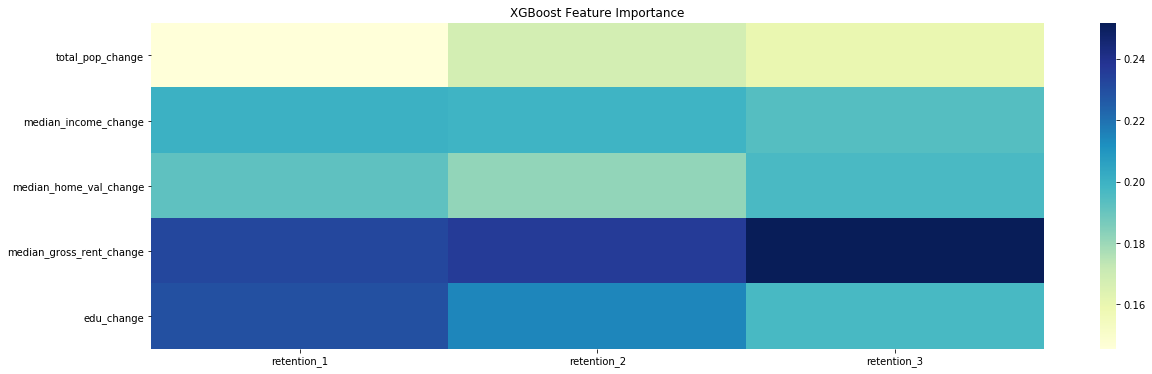

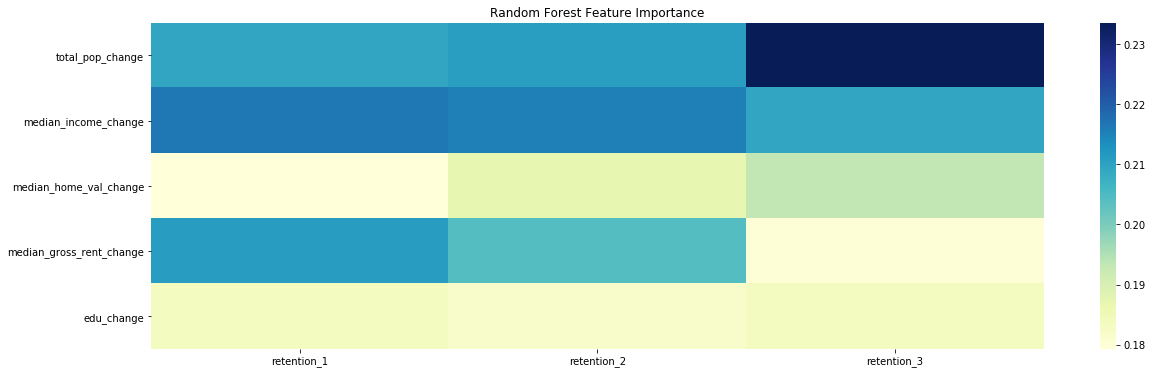

In [14]:
feat_imp = [model.feature_importances_ for model in xgb_model.values()]
feat_imp = pd.DataFrame(feat_imp, columns = X.columns)
feat_imp.index = y.columns

plt.figure(figsize=(20,6))
heatmap(feat_imp.T, cmap="YlGnBu")
plt.title('XGBoost Feature Importance')
# plt.savefig("featimp_gent_XGB_CLASSIFIER.png")

feat_imp = [model.feature_importances_ for model in rf_model.values()]
feat_imp = pd.DataFrame(feat_imp, columns = X.columns)
feat_imp.index = y.columns

plt.figure(figsize=(20,6))
heatmap(feat_imp.T, cmap="YlGnBu")
plt.title('Random Forest Feature Importance')

# plt.savefig("featimp_gent_RF_CLASSIFIER.png")

In [15]:
print(result)
print(max(result[0]))
print(max(result[1]))
# result.to_csv('model_resuls.csv', index = False)

               model         0         1
retention_1       RF  0.014149 -0.010716
retention_2       RF  0.132002  0.115398
retention_3       RF  0.141862  0.128775
retention_1  XGBoost  0.015089 -0.008904
retention_2  XGBoost  0.131384  0.116217
retention_3  XGBoost  0.141657  0.129663
0.1418616324462365
0.12966349361415963


In [ ]:
test_score

In [42]:
# plot changes in census data over time for a given zip code

fig = go.Figure()

for col in dfs[0].columns:
    inc = []
    for d in dfs:
        inc.append(int(d.loc[d['zipcode'] == 10467, col]))
    fig.add_trace(go.Scatter(x=years, y=inc, mode='lines', name=col))

fig.show()


df_2014